In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)
import tensorflow_probability as tfp

2024-03-15 22:30:11.873026: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 22:30:11.873048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 22:30:11.873611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 0. Parameters

In [3]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

2024-03-15 22:30:13.502737: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 22:30:13.510926: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 22:30:13.514547: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

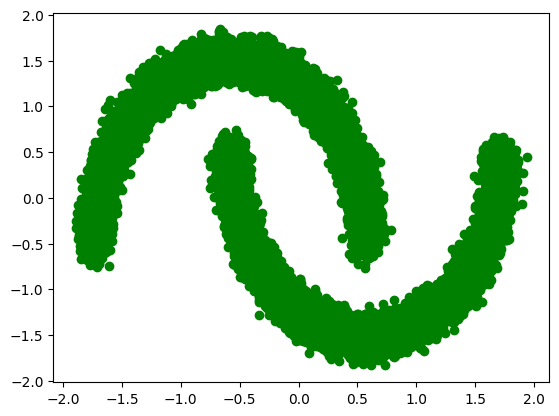

In [4]:
# Load the data
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(
    normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green"
)
plt.show()

# 2. Build the RealNVP network

In [5]:
def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=input_dim)

    s_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        input_dim, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

In [6]:
class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

# 3. Train the RealNVP network

In [7]:
# Compile and train the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [8]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 30 == 0:
            x, z, samples = self.generate()
            self.display(
                x,
                z,
                samples,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_samples=3000)

Epoch 1/300


2024-03-15 22:30:17.173269: I external/local_xla/xla/service/service.cc:168] XLA service 0x7b5d70516760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-15 22:30:17.173286: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-15 22:30:17.177300: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-15 22:30:17.191796: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1710552617.249773  487433 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/118 [===========================>..] - ETA: 0s - loss: 2.5517
Saved to ./output/generated_img_000.png


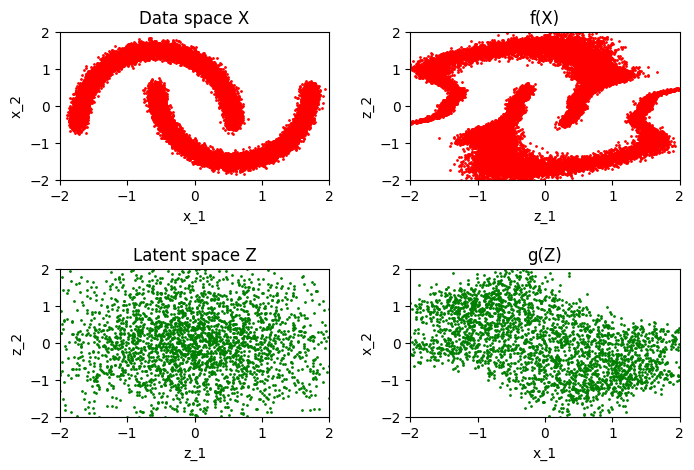

118/118 [==============================] - 5s 14ms/step - loss: 2.5449
Epoch 2/300
118/118 [==============================] - 1s 6ms/step - loss: 2.3308
Epoch 3/300
118/118 [==============================] - 1s 6ms/step - loss: 2.1957
Epoch 4/300
118/118 [==============================] - 1s 7ms/step - loss: 2.0965
Epoch 5/300
118/118 [==============================] - 1s 6ms/step - loss: 2.0528
Epoch 6/300
118/118 [==============================] - 1s 7ms/step - loss: 2.0006
Epoch 7/300
118/118 [==============================] - 1s 7ms/step - loss: 1.9059
Epoch 8/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7901
Epoch 9/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7737
Epoch 10/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7692
Epoch 11/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7616
Epoch 12/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7493
Epoch 13/300
118/118 [==

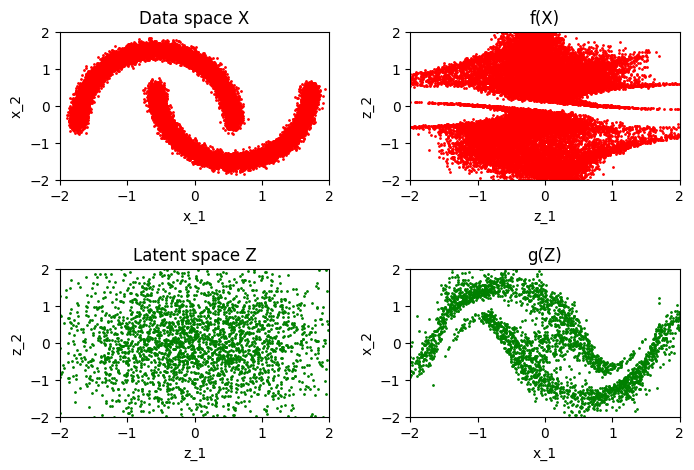

118/118 [==============================] - 1s 12ms/step - loss: 1.7245
Epoch 32/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7282
Epoch 33/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7248
Epoch 34/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7276
Epoch 35/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7227
Epoch 36/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7235
Epoch 37/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7333
Epoch 38/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7232
Epoch 39/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7196
Epoch 40/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7209
Epoch 41/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7226
Epoch 42/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7224
Epoch 43/300
118

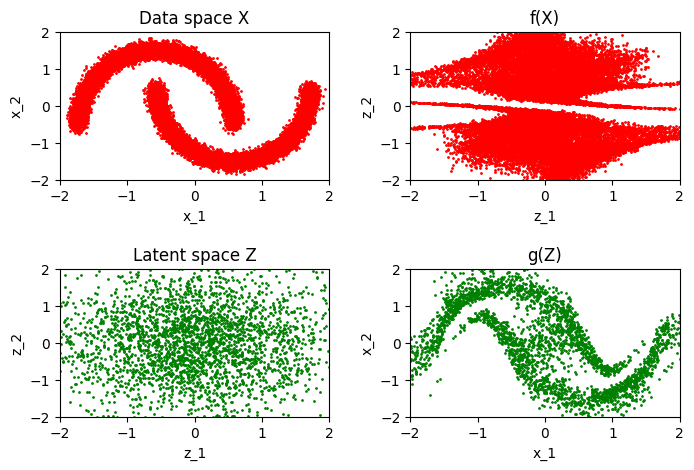

118/118 [==============================] - 1s 12ms/step - loss: 1.7204
Epoch 62/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7188
Epoch 63/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7204
Epoch 64/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7243
Epoch 65/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7154
Epoch 66/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7960
Epoch 67/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7275
Epoch 68/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7176
Epoch 69/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7280
Epoch 70/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7192
Epoch 71/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7212
Epoch 72/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7186
Epoch 73/300
118

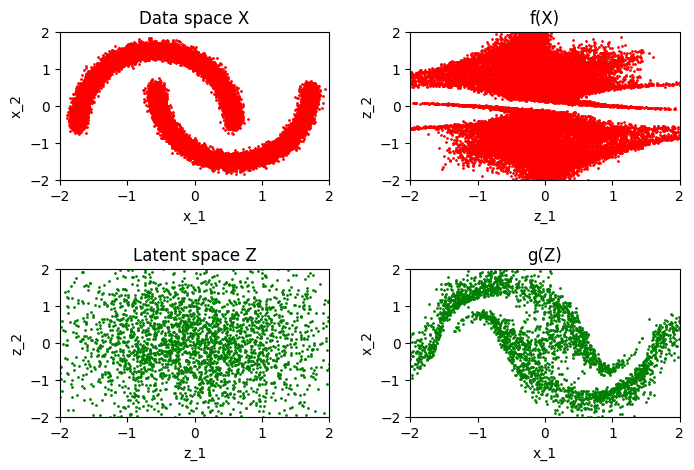

118/118 [==============================] - 2s 14ms/step - loss: 1.7169
Epoch 92/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7224
Epoch 93/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7148
Epoch 94/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7151
Epoch 95/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7179
Epoch 96/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7188
Epoch 97/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7209
Epoch 98/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7193
Epoch 99/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7159
Epoch 100/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7149
Epoch 101/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7142
Epoch 102/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7169
Epoch 103/300

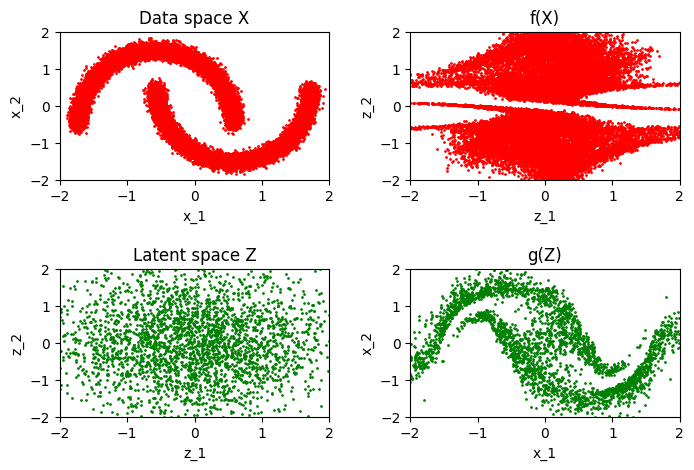

118/118 [==============================] - 1s 12ms/step - loss: 1.7141
Epoch 122/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7136
Epoch 123/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7151
Epoch 124/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7146
Epoch 125/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7144
Epoch 126/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7091
Epoch 127/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7131
Epoch 128/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7144
Epoch 129/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7138
Epoch 130/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7152
Epoch 131/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7110
Epoch 132/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7106
Epoch

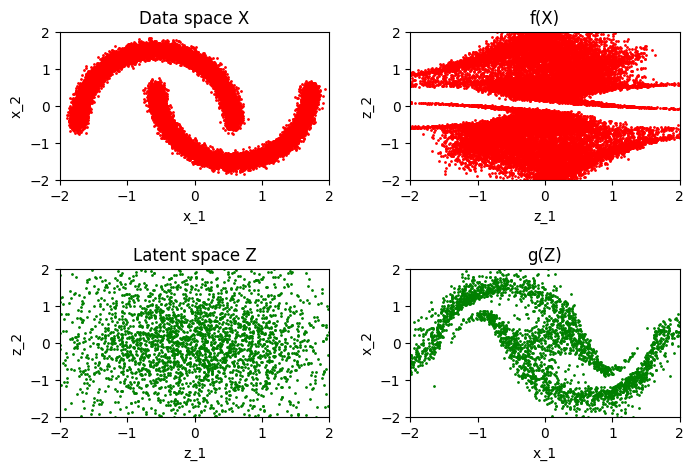

118/118 [==============================] - 1s 11ms/step - loss: 1.7060
Epoch 152/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7113
Epoch 153/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7105
Epoch 154/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7190
Epoch 155/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7077
Epoch 156/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7123
Epoch 157/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7140
Epoch 158/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7199
Epoch 159/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7127
Epoch 160/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7113
Epoch 161/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7098
Epoch 162/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7148
Epoch

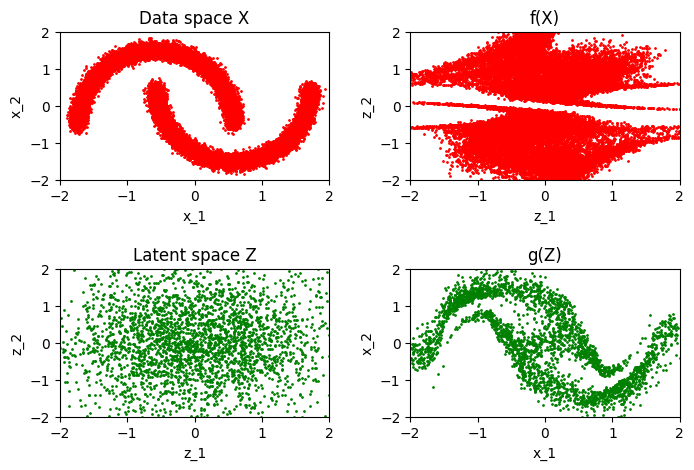

118/118 [==============================] - 1s 12ms/step - loss: 1.7110
Epoch 182/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7143
Epoch 183/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7103
Epoch 184/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7131
Epoch 185/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7090
Epoch 186/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7110
Epoch 187/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7161
Epoch 188/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7057
Epoch 189/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7087
Epoch 190/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7170
Epoch 191/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7107
Epoch 192/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7123
Epoch

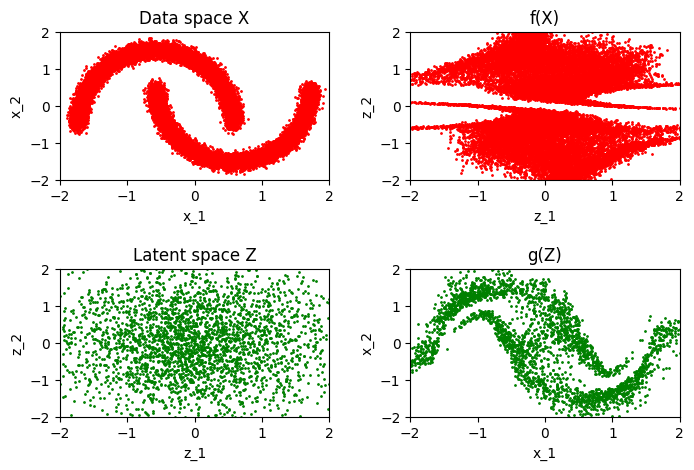

118/118 [==============================] - 1s 12ms/step - loss: 1.7118
Epoch 212/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7096
Epoch 213/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7092
Epoch 214/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7136
Epoch 215/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7078
Epoch 216/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7104
Epoch 217/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7082
Epoch 218/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7091
Epoch 219/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7105
Epoch 220/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7092
Epoch 221/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7064
Epoch 222/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7120
Epoch

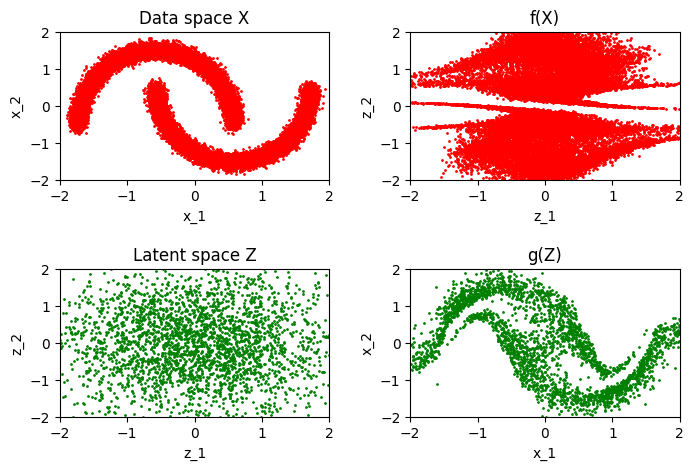

118/118 [==============================] - 1s 12ms/step - loss: 1.7099
Epoch 242/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7062
Epoch 243/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7082
Epoch 244/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7093
Epoch 245/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7086
Epoch 246/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7056
Epoch 247/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7073
Epoch 248/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7102
Epoch 249/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7123
Epoch 250/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7084
Epoch 251/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7060
Epoch 252/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7080
Epoch

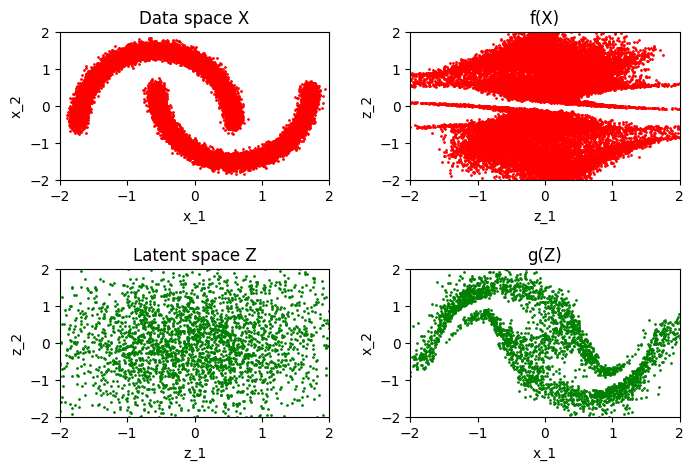

118/118 [==============================] - 1s 12ms/step - loss: 1.7054
Epoch 272/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7044
Epoch 273/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7118
Epoch 274/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7157
Epoch 275/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7109
Epoch 276/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7103
Epoch 277/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7060
Epoch 278/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7107
Epoch 279/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7119
Epoch 280/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7092
Epoch 281/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7062
Epoch 282/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7056
Epoch

In [9]:
model.fit(
    normalized_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

# 4. Generate images

In [10]:
x, z, samples = img_generator_callback.generate()

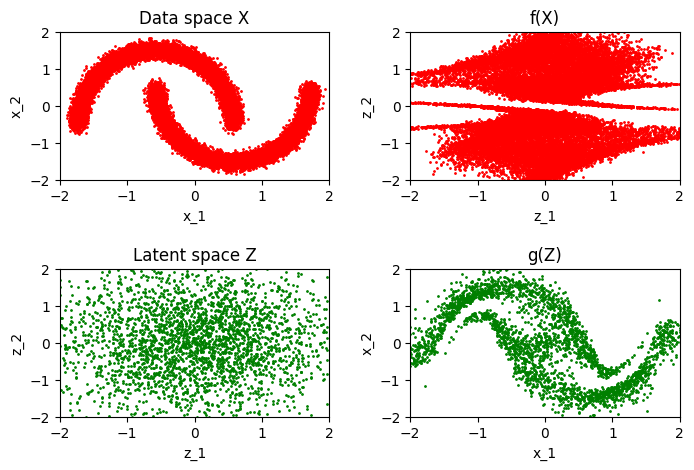

In [11]:
img_generator_callback.display(x, z, samples)